# **MT5 Question Answering Model**

In [ ]:
# install required packages
!pip install transformers
!pip install sentencepiece
!pip install torchtext==0.10.0
!pip install --quiet pytorch-lightning==1.2.10
!pip install indic-nlp-library
!pip install langdetect
!pip install deep-translator
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 47.1 MB/s 
     |████████████████████████████████| 163 kB 62.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.1 MB/s 
     |████████████████████████████████| 831.4 MB 3.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependen

In [ ]:
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from indicnlp.tokenize import indic_tokenize 
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import default_data_collator, Trainer, TrainingArguments

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


- **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- **Move in the directory**

In [ ]:
cd "/content/drive/MyDrive/chaii-hindi-and-tamil-question-answering"

/content/drive/MyDrive/chaii-hindi-and-tamil-question-answering


- **Read dataset**

In [ ]:
data = pd.read_csv("train.csv")

- **Print sample data**

In [ ]:
data.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


- **Dataset size**

In [ ]:
print("Number of rows in the dataset: ",data.shape[0])
print("Number of columns in the dataset: ",data.shape[1])

Number of rows in the dataset:  1114
Number of columns in the dataset:  6


- **Column names in the dataset**

In [ ]:
print("Column names in the dataset: ",list(data.columns))

Column names in the dataset:  ['id', 'context', 'question', 'answer_text', 'answer_start', 'language']


- **Input features columns**

In [ ]:
print("Input data column names in the dataset: ",data.columns[1])

Input data column names in the dataset:  context


- **Output columns**

In [ ]:
print("Output data column names in the dataset: ",list(data.columns[2:4]))

Output data column names in the dataset:  ['question', 'answer_text']


- **Find frequency of hindi and tamil instances**

In [ ]:
freq = np.unique(data['language'],return_counts=True)
print("Total instances of", freq[0][0],"language: ", freq[1][0])
print("Total instances of", freq[0][1],"language: ", freq[1][1])

Total instances of hindi language:  746
Total instances of tamil language:  368


- **Find null values in the dataset**

In [ ]:
data.isna().sum()

id              0
context         0
question        0
answer_text     0
answer_start    0
language        0
dtype: int64

- **There are no null values in the dataset**

In [ ]:
print("Null values in context:",data.isna().sum()[1])
print("Null values in question:",data.isna().sum()[2])
print("Null values in answer_text:",data.isna().sum()[3])
print("Null values in answer_start:",data.isna().sum()[4])
print("Null values in language:",data.isna().sum()[5])

Null values in context: 0
Null values in question: 0
Null values in answer_text: 0
Null values in answer_start: 0
Null values in language: 0


- **Find duplicate values in the dataset**
  - There are no duplicate values 

In [ ]:
print("Count of duplicate values: ",data['id'].duplicated().sum())

Count of duplicate values:  0


- **Tokenize text**

In [ ]:
from indicnlp.tokenize import indic_tokenize 

In [ ]:
def tokenize_text(text):
  text = indic_tokenize.trivial_tokenize(text)
  return text

In [ ]:
data['tok_answer'] = data['answer_text'].apply(tokenize_text)
data['tok_context'] = data['context'].apply(tokenize_text)
data['tok_question'] = data['question'].apply(tokenize_text)

### **Before data processing**

- **Most common 50 words in the context**

In [ ]:
from collections import Counter
# count of unique tokens in dataset
context_total = Counter()
data['tok_context'].apply(context_total.update)
context_total.most_common(50)

[(',', 76127),
 ('के', 62145),
 ('।', 58512),
 ('.', 55263),
 ('में', 47954),
 ('है', 36401),
 ('की', 31931),
 ('और', 26686),
 ('से', 23519),
 ('का', 23359),
 (')', 23100),
 ('(', 23062),
 ('[', 21415),
 (']', 21383),
 ('को', 19803),
 ('-', 19117),
 ('एक', 13885),
 ('हैं', 13868),
 ('\n', 12357),
 ('पर', 11980),
 ('ने', 11214),
 (':', 10634),
 ('"', 9513),
 ('भी', 8877),
 ('किया', 8841),
 ('था', 8675),
 ('लिए', 7901),
 ('गया', 7048),
 ('यह', 6742),
 ('कि', 6435),
 ('इस', 5886),
 ('कर', 5539),
 ('ही', 5267),
 ('रूप', 5007),
 ('மற்றும்', 4893),
 ('जो', 4766),
 ('साथ', 4616),
 ("'", 4366),
 ('नहीं', 4333),
 ('करने', 4327),
 ('हो', 4267),
 ('जाता', 4232),
 ('थे', 4184),
 ('द्वारा', 4131),
 ('बाद', 4036),
 ('तथा', 3916),
 ('दिया', 3784),
 ('तक', 3704),
 ('ஒரு', 3423),
 ('थी', 3359)]

- **Most common 50 words in question**

In [ ]:
question_total = Counter()
data['tok_question'].apply(question_total.update)
question_total.most_common(50)

[('?', 1085),
 ('है', 370),
 ('का', 297),
 ('की', 231),
 ('में', 205),
 ('किस', 192),
 ('था', 179),
 ('के', 175),
 ('क्या', 160),
 ('कब', 86),
 ('नाम', 82),
 ("'", 81),
 ('हुआ', 75),
 ('कौन', 75),
 ('எது', 72),
 ('को', 70),
 ('थी', 67),
 ('எப்போது', 65),
 ('என்ன', 61),
 ('से', 56),
 ('किया', 53),
 ('भारत', 52),
 ('कितने', 51),
 ('जन्म', 51),
 ('हुई', 46),
 ('எந்த', 45),
 ('कहाँ', 44),
 ('யார்', 43),
 ('वर्ष', 43),
 ('थे', 42),
 ('गया', 42),
 ('स्थित', 41),
 ('எத்தனை', 39),
 ('जाता', 39),
 ('किसने', 36),
 ('कितनी', 33),
 ('सबसे', 33),
 ('ने', 33),
 ('உள்ளன', 32),
 ('भाषा', 31),
 ('हैं', 29),
 ('.', 28),
 ('कितना', 27),
 ('द्वारा', 26),
 ('पर', 26),
 ('தலைநகரம்', 25),
 ('राजधानी', 25),
 ('பிறந்தார்', 24),
 ('நாட்டின்', 24),
 ('मृत्यु', 24)]

- **Most common 50 words in answer**

In [ ]:
answer_total = Counter()
data['tok_answer'].apply(answer_total.update)
answer_total.most_common(50)

[(',', 109),
 ('.', 70),
 ('के', 31),
 ('-', 21),
 ('और', 21),
 ('वर्ग', 15),
 ('किलोमीटर', 15),
 ('1', 14),
 ('से', 14),
 ('கி', 12),
 ('15', 12),
 ('मीटर', 12),
 ('में', 12),
 ('जनवरी', 11),
 ('अक्टूबर', 11),
 ('ई', 11),
 ('अप्रैल', 10),
 ('7', 9),
 ('जून', 9),
 ('5', 8),
 ('ஆண்டு', 8),
 ('18', 8),
 ('जुलाई', 8),
 ('सितम्बर', 8),
 ("'", 8),
 ('12', 7),
 ('भारत', 7),
 ('महाराष्ट्र', 7),
 ('है', 7),
 ('மற்றும்', 6),
 ('3', 6),
 ('1947', 6),
 ('22', 6),
 ('दिल्ली', 6),
 ('१४', 6),
 ('नवम्बर', 6),
 ('तीन', 6),
 ('किमी', 6),
 ('भाषा', 6),
 ('चार्ल्स', 6),
 ('०००', 6),
 ('प्रदेश', 6),
 ('दो', 6),
 ('या', 6),
 ('"', 6),
 ('2001', 5),
 ('10', 5),
 ('000', 5),
 ('மீ', 5),
 ('ஆம்', 5)]

In [ ]:
del data['tok_question']
del data['tok_context']
del data['tok_answer']

### **Data processing**
  - We analyze that most repeated words in the dataset includes punctuations or stopwords
  - We will clean data by removing punctuations and stopwords

- **Text cleaning**
  - **Remove hyperlinks**
  - **Remove punctuations**
  - **Remove more than one white space e.g. \n etc.**

In [ ]:
import re
import string
def clean_text(text):
  
  # remove hyperlinks 
  text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
  text = re.sub('http|htt|https'," ",text)
  text = text.replace("।"," ")
  text = text.translate(str.maketrans('', '', string.punctuation))
  # remove more than one space, lower case text (there are some english words as well)
  text = re.sub('\s+',' ',text).lower().strip()
  
  return text

In [ ]:
data['clean_context'] = data['context'].apply(clean_text)
data['clean_question'] = data['question'].apply(clean_text)
data['clean_answer'] = data['answer_text'].apply(clean_text)

In [ ]:
del data['context']
del data['question']
del data['answer_text']

In [ ]:
hindi_data = data.loc[data['language']=='hindi'].reset_index(drop=True)
tamil_data = data.loc[data['language']=='tamil'].reset_index(drop=True)

In [ ]:
from spacy.lang.hi import Hindi
from spacy.lang.ta import Tamil

In [ ]:
def remove_stopwords(text):
  doc = nlp(text)
  return " ".join([token.text for token in doc if not token.is_stop])


In [ ]:
nlp = Hindi()
hindi_data['clean_context'] = hindi_data['clean_context'].apply(remove_stopwords)
hindi_data['clean_question'] = hindi_data['clean_question'].apply(remove_stopwords)
hindi_data['clean_answer'] = hindi_data['clean_answer'].apply(remove_stopwords)

In [ ]:
nlp = Tamil()
tamil_data['clean_context'] = tamil_data['clean_context'].apply(remove_stopwords)
tamil_data['clean_question'] = tamil_data['clean_question'].apply(remove_stopwords)
tamil_data['clean_answer'] = tamil_data['clean_answer'].apply(remove_stopwords)

In [ ]:
def text_lemmatize(text):
  doc = nlp(text)
  return " ".join([token.lemma_ if token.lemma_ else token.text for token in doc])

In [ ]:
nlp = Hindi()
hindi_data['clean_context'] = hindi_data['clean_context'].apply(text_lemmatize)
hindi_data['clean_question'] = hindi_data['clean_question'].apply(text_lemmatize)
hindi_data['clean_answer'] = hindi_data['clean_answer'].apply(text_lemmatize)

In [ ]:
nlp = Tamil()
tamil_data['clean_context'] = tamil_data['clean_context'].apply(text_lemmatize)
tamil_data['clean_question'] = tamil_data['clean_question'].apply(text_lemmatize)
tamil_data['clean_answer'] = tamil_data['clean_answer'].apply(text_lemmatize)

In [ ]:
processed_data = pd.concat([hindi_data,tamil_data])

In [ ]:
processed_data.head()

,id,answer_start,language,clean_context,clean_question,clean_answer
0,416091aeb,935,hindi,विषाणु अकोशिकीय अतिसूक्ष्म जीव केवल जीवित कोशि...,सन १८८६ किसने बताया तम्बाकू मोजेक रोग विशेष प्...,एडोल्फ मेयर
1,9d274ae3c,166,hindi,फ्लोरीन रासायनिक तत्व आवर्त सारणी periodic tab...,फ्लोरीन परमाणु संख्या क्या,9
2,da7397c5e,26,hindi,सीऐटल अंग्रेजी seattle अमेरिका वाशिंगटन राज्य ...,सीटल शहर कहाँ स्थित,अमेरिका वाशिंगटन राज्य
3,661880e43,2762,hindi,सूर्य अथवा सूरज सौरमंडल केन्द्र स्थित तारा जिस...,पृथ्वी सूर्य परिक्रमा कितने दिन लागते,28 दिनों
4,3e3a2bed4,51,hindi,दिल्ली नगर निगम शहर नगर निगम दिल्ली नौ जिलों क...,दिल्ली नगर निगम दिल्ली कितने जिलों कार्यरत,नौ जिलों


In [ ]:
# Shuffle data to evenly scatter data
processed_data = processed_data.sample(frac=1).reset_index(drop=True)

In [ ]:
processed_data['tok_answer'] = processed_data['clean_answer'].apply(tokenize_text)
processed_data['tok_context'] = processed_data['clean_context'].apply(tokenize_text)
processed_data['tok_question'] = processed_data['clean_question'].apply(tokenize_text)

In [ ]:
processed_data['len_tok_context'] = processed_data['tok_context'].str.len()
processed_data['len_tok_answer'] = processed_data['tok_answer'].str.len()
processed_data['len_tok_question'] = processed_data['tok_question'].str.len()


In [ ]:
processed_data.loc[processed_data['len_tok_context']==0]

,id,answer_start,language,clean_context,clean_question,clean_answer,tok_answer,tok_context,tok_question,len_tok_context,len_tok_answer,len_tok_question


In [ ]:
processed_data.loc[processed_data['len_tok_question']==0]

,id,answer_start,language,clean_context,clean_question,clean_answer,tok_answer,tok_context,tok_question,len_tok_context,len_tok_answer,len_tok_question


In [ ]:
processed_data.loc[processed_data['len_tok_answer']==0]

,id,answer_start,language,clean_context,clean_question,clean_answer,tok_answer,tok_context,tok_question,len_tok_context,len_tok_answer,len_tok_question


In [ ]:
processed_data.describe()

,answer_start,len_tok_context,len_tok_answer,len_tok_question
count,1114.000000,1114.000000,1114.000000,1114.000000
mean,1709.403052,1152.026032,1.995512,4.622083
std,3730.169300,1083.353489,1.849936,1.514796
min,0.000000,18.000000,1.000000,2.000000
25%,67.000000,412.000000,1.000000,4.000000
50%,373.000000,789.500000,2.000000,4.000000
75%,1387.750000,1487.750000,2.000000,5.000000
max,40991.000000,5647.000000,35.000000,13.000000


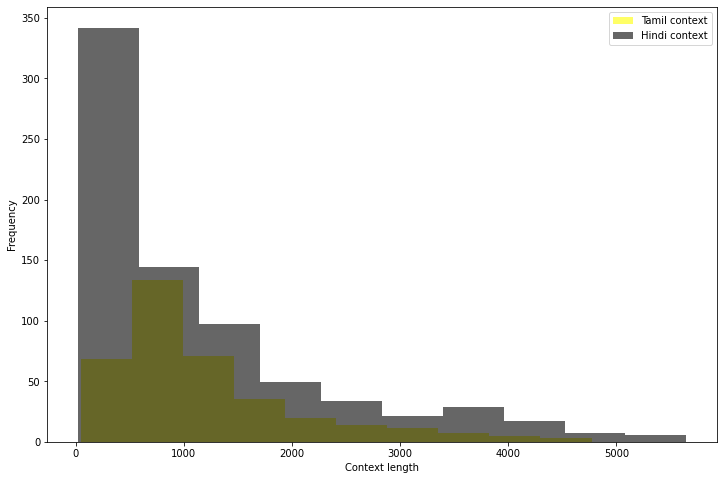

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
processed_data[processed_data.language == "tamil"].len_tok_context.plot(kind='hist', color='yellow', 
                                       label='Tamil context', alpha=0.6)
processed_data[processed_data.language == "hindi"].len_tok_context.plot(kind='hist', color='black', 
                                       label='Hindi context', alpha=0.6)




plt.legend()
plt.xlabel("Context length")
plt.show()

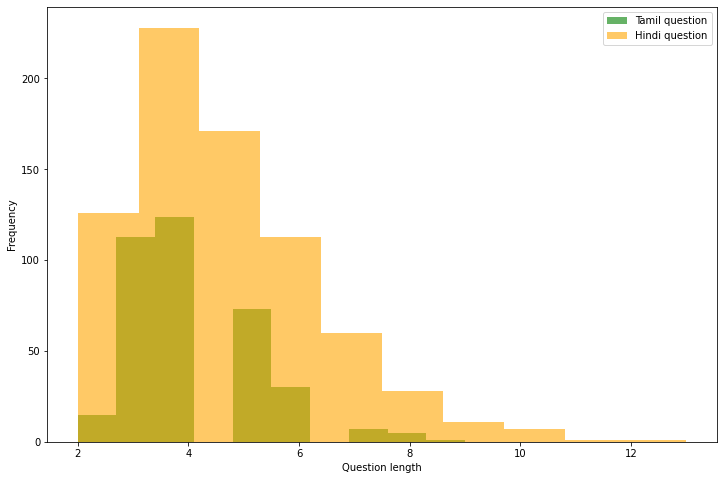

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
processed_data[processed_data.language == "tamil"].len_tok_question.plot(kind='hist', color='green', 
                                       label='Tamil question', alpha=0.6)
processed_data[processed_data.language == "hindi"].len_tok_question.plot(kind='hist', color='orange', 
                                       label='Hindi question', alpha=0.6)




plt.legend()
plt.xlabel("Question length")
plt.show()

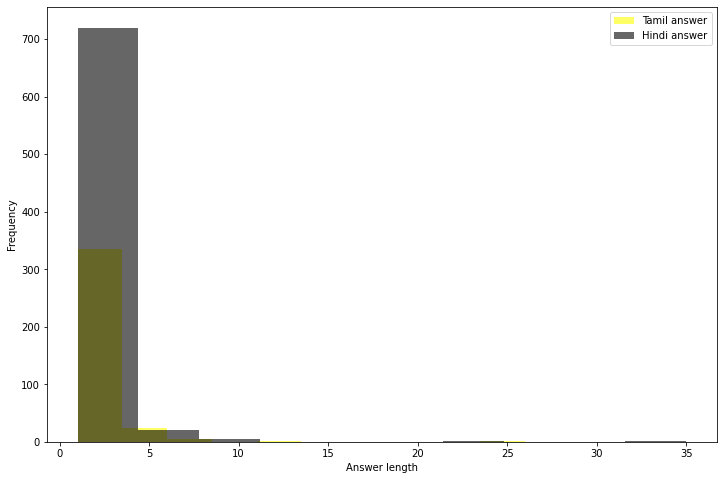

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
processed_data[processed_data.language == "tamil"].len_tok_answer.plot(kind='hist', color='yellow', 
                                       label='Tamil answer', alpha=0.6)
processed_data[processed_data.language == "hindi"].len_tok_answer.plot(kind='hist', color='black', 
                                       label='Hindi answer', alpha=0.6)




plt.legend()
plt.xlabel("Answer length")
plt.show()

### **After data processing**

In [ ]:
processed_data.columns

Index(['id', 'answer_start', 'language', 'clean_context', 'clean_question',
       'clean_answer', 'tok_answer', 'tok_context', 'tok_question',
       'len_tok_context', 'len_tok_answer', 'len_tok_question'],
      dtype='object')

### **Most common words in Context**

In [ ]:
context_total = Counter()
processed_data['tok_context'].apply(context_total.update)
context_total.most_common(50)

[('रूप', 4989),
 ('जाता', 4229),
 ('तथा', 3931),
 ('भारत', 3267),
 ('नाम', 2344),
 ('समय', 2178),
 ('भारतीय', 2076),
 ('उन्होंने', 2058),
 ('अन्य', 1943),
 ('कारण', 1910),
 ('क्षेत्र', 1882),
 ('अधिक', 1861),
 ('ஆம்', 1846),
 ('राज्य', 1621),
 ('गए', 1616),
 ('गई', 1589),
 ('वर्ष', 1500),
 ('1', 1426),
 ('प्रकार', 1423),
 ('प्राप्त', 1342),
 ('लिया', 1332),
 ('युद्ध', 1327),
 ('–', 1326),
 ('2', 1291),
 ('लगभग', 1290),
 ('जाती', 1266),
 ('विश्व', 1235),
 ('जाने', 1232),
 ('स्थित', 1207),
 ('कम', 1198),
 ('शामिल', 1193),
 ('देश', 1181),
 ('बीच', 1179),
 ('अनुसार', 1176),
 ('पूर्व', 1164),
 ('दी', 1147),
 ('இந்திய', 1120),
 ('निर्माण', 1104),
 ('प्रमुख', 1094),
 ('भाषा', 1078),
 ('जाते', 1070),
 ('भाग', 1067),
 ('जिसमें', 1050),
 ('ஆண்டு', 1045),
 ('लोग', 1031),
 ('of', 1016),
 ('जीवन', 1007),
 ('मुख्य', 994),
 ('सरकार', 980),
 ('विश्वविद्यालय', 973)]

In [ ]:
question_total = Counter()
processed_data['tok_question'].apply(question_total.update)
question_total.most_common(50)

[('क्या', 160),
 ('कब', 86),
 ('नाम', 82),
 ('எது', 72),
 ('எப்போது', 65),
 ('भारत', 52),
 ('कितने', 51),
 ('जन्म', 51),
 ('कहाँ', 44),
 ('वर्ष', 42),
 ('स्थित', 41),
 ('जाता', 39),
 ('எத்தனை', 39),
 ('किसने', 36),
 ('कितनी', 33),
 ('भाषा', 29),
 ('राजधानी', 25),
 ('தலைநகரம்', 25),
 ('பிறந்தார்', 24),
 ('நாட்டின்', 24),
 ('मृत्यु', 24),
 ('क्षेत्रफल', 22),
 ('विश्व', 22),
 ('स्थापना', 22),
 ('´', 22),
 ('साल', 21),
 ('पिता', 20),
 ('वैज्ञानिक', 20),
 ('राज्य', 19),
 ('கண்டுபிடித்தவர்', 19),
 ('பரப்பளவு', 19),
 ('எங்கு', 18),
 ('நிறுவப்பட்டது', 18),
 ('இந்தியாவில்', 18),
 ('धर्म', 18),
 ('பெயர்', 17),
 ('भारतीय', 17),
 ('शहर', 17),
 ('देश', 17),
 ('मुख्यालय', 17),
 ('மிகப்பெரிய', 16),
 ('किसके', 16),
 ('मानव', 15),
 ('கண்டுபிடிக்கப்பட்டது', 15),
 ('पहला', 15),
 ('फिल्म', 15),
 ('ஆண்டு', 14),
 ('உலகின்', 14),
 ('संस्थापक', 13),
 ('पहली', 13)]

In [ ]:
answer_total = Counter()
processed_data['tok_answer'].apply(answer_total.update)
answer_total.most_common(50)

[('किलोमीटर', 15),
 ('15', 13),
 ('मीटर', 12),
 ('जनवरी', 11),
 ('अक्टूबर', 11),
 ('अप्रैल', 10),
 ('7', 9),
 ('जून', 9),
 ('ஆண்டு', 8),
 ('', 8),
 ('जुलाई', 8),
 ('18', 8),
 ('ई', 8),
 ('सितम्बर', 8),
 ('महाराष्ट्र', 7),
 ('भारत', 7),
 ('किमी', 7),
 ('12', 7),
 ('भाषा', 6),
 ('दिल्ली', 6),
 ('प्रदेश', 6),
 ('तीन', 6),
 ('चार्ल्स', 6),
 ('1947', 6),
 ('22', 6),
 ('5', 6),
 ('1949', 5),
 ('கிமு', 5),
 ('ஆம்', 5),
 ('1948', 5),
 ('उत्तर', 5),
 ('दिसम्बर', 5),
 ('कि॰मी॰', 5),
 ('वर्ष', 5),
 ('3', 5),
 ('भारतीय', 5),
 ('2001', 5),
 ('1945', 5),
 ('अगस्त', 5),
 ('मई', 5),
 ('नई', 4),
 ('मध्य', 4),
 ('शहर', 4),
 ('செப்டம்பர்', 4),
 ('17', 4),
 ('மாதம்', 4),
 ('6', 4),
 ('24', 4),
 ('சனவரி', 4),
 ('लाल', 4)]

In [ ]:
hindi = data.loc[data['language']=='hindi']
tamil = data.loc[data['language']=='tamil']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
def freq_generator(lan):
  con_freq = Counter()
  que_freq = Counter()
  ans_freq = Counter()
  processed_data['tok_context'].loc[processed_data['language']==lan].apply(con_freq.update)
  processed_data['tok_question'].loc[processed_data['language']==lan].apply(que_freq.update)
  processed_data['tok_answer'].loc[processed_data['language']==lan].apply(ans_freq.update)
  return con_freq, que_freq, ans_freq

In [ ]:
def generate_wordcloud(data, font_path):
  wordcloud = WordCloud(background_color="black", font_path= font_path).generate_from_frequencies(data)

  # define plotting figure size
  plt.figure(figsize=(12,10))
  # Display the generated image:
  # the matplotlib way:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  # dispaly figure size
  plt.clf()


Word cloud of most frequent words in context:


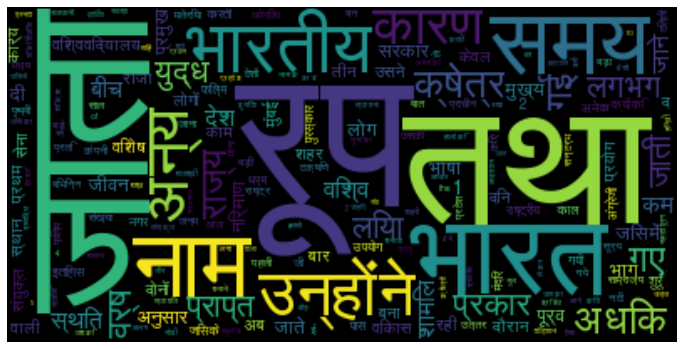



Word cloud of most frequent words in question:


<Figure size 432x288 with 0 Axes>

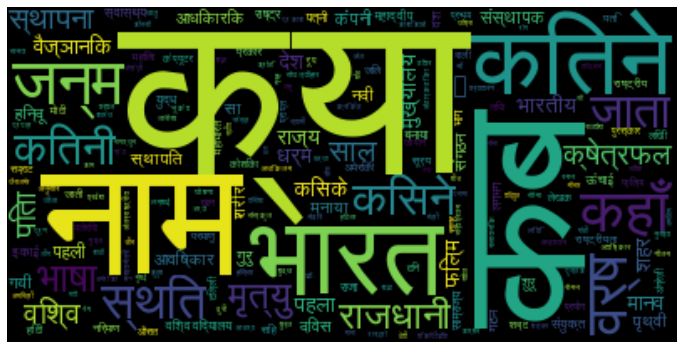



Word cloud of most frequent words in answer:


<Figure size 432x288 with 0 Axes>

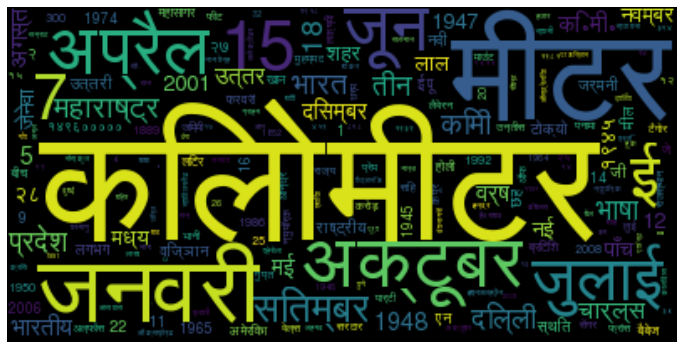

<Figure size 432x288 with 0 Axes>

In [ ]:
hindi_font = "/content/drive/MyDrive/chaii-hindi-and-tamil-question-answering/Devanagari/gargi.ttf"
lan = "hindi"
con_freq, que_freq, ans_freq = freq_generator(lan)
print("\nWord cloud of most frequent words in context:")
generate_wordcloud(con_freq, hindi_font)
print("\n\nWord cloud of most frequent words in question:")
generate_wordcloud(que_freq, hindi_font)
print("\n\nWord cloud of most frequent words in answer:")
generate_wordcloud(ans_freq, hindi_font)


Word cloud of most frequent words in context:


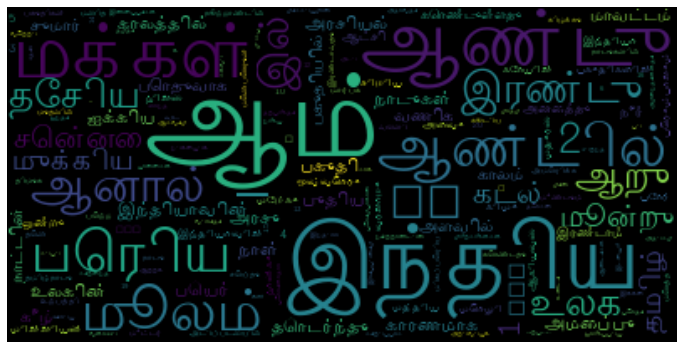



Word cloud of most frequent words in question:


<Figure size 432x288 with 0 Axes>

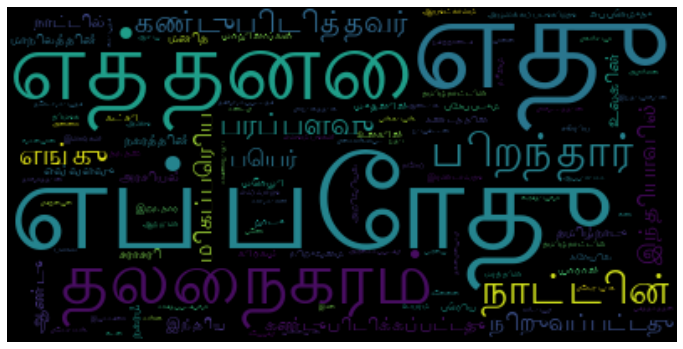



Word cloud of most frequent words in answer:


<Figure size 432x288 with 0 Axes>

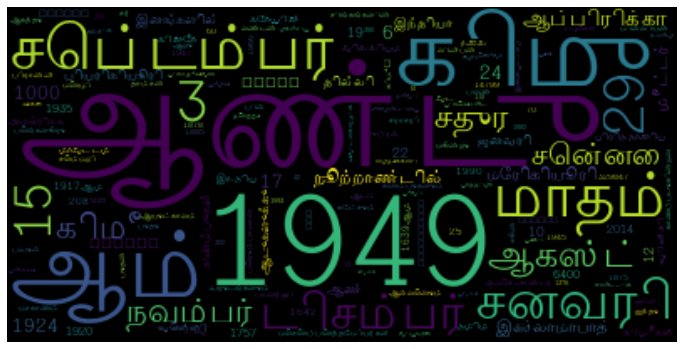

<Figure size 432x288 with 0 Axes>

In [ ]:
tamil_font = "/content/drive/MyDrive/chaii-hindi-and-tamil-question-answering/Devanagari/Lohit-Tamil.ttf"
lan = "tamil"
con_freq, que_freq, ans_freq = freq_generator(lan)
print("\nWord cloud of most frequent words in context:")
generate_wordcloud(con_freq, tamil_font)
print("\n\nWord cloud of most frequent words in question:")
generate_wordcloud(que_freq, tamil_font)
print("\n\nWord cloud of most frequent words in answer:")
generate_wordcloud(ans_freq, tamil_font)

In [ ]:
from langdetect import detect_langs
def dtct_lang(text):
  try:
    return detect_langs(text)
  except:
    return "numeric"

In [ ]:
processed_data['langs_answer'] = processed_data['clean_answer'].apply(dtct_lang)
processed_data['langs_context'] = processed_data['clean_context'].apply(dtct_lang)
processed_data['langs_question'] = processed_data['clean_question'].apply(dtct_lang)

In [ ]:
processed_data.head()

,id,answer_start,language,clean_context,clean_question,clean_answer,tok_answer,tok_context,tok_question,len_tok_context,len_tok_answer,len_tok_question,langs_answer,langs_context,langs_question
0,23d8f8654,1276,hindi,राम दास गुरू राम दास punjabi ਸ੍ਰੀ ਗੁਰੂ ਰਾਮ ਦਾਸ...,गुरु राम दास पत्नी,बीबी भानी जी,"[बीबी, भानी, जी]","[राम, दास, गुरू, राम, दास, punjabi, ਸ੍ਰੀ, ਗੁਰੂ...","[गुरु, राम, दास, पत्नी]",478,3,4,[hi:0.9999973107613034],[hi:0.9999955589891637],[ne:0.9999984316221241]
1,1431f3af8,8,tamil,தஞ்சைப் பிரகதீசுவரர் கோயில் தஞ்சைப் பெரிய கோயி...,தஞ்சாவூர் மாவட்டத்தின் மிகப்பெரிய கோயில் எது,பிரகதீசுவரர் கோயில்,"[பிரகதீசுவரர், கோயில்]","[தஞ்சைப், பிரகதீசுவரர், கோயில், தஞ்சைப், பெரிய...","[தஞ்சாவூர், மாவட்டத்தின், மிகப்பெரிய, கோயில், ...",1493,2,5,[ta:0.9999999545242855],[ta:0.9999999999977018],[ta:0.9999999794738379]
2,f7b839902,178,hindi,साम्राज्य पादप विभाग मैंगोलियोफाइटा मैंगोलियोफ...,आंवले पौधे औसत ऊंचाई कितनी,२० फीट २५ फुट,"[२०, फीट, २५, फुट]","[साम्राज्य, पादप, विभाग, मैंगोलियोफाइटा, मैंगो...","[आंवले, पौधे, औसत, ऊंचाई, कितनी]",774,4,5,[mr:0.9999953179664938],[hi:0.9999957764469704],"[hi:0.7142857391701127, mr:0.28571426033487757]"
3,d3de7b845,898,tamil,சீனிவாச இராமானுஜன் டிசம்பர் 22 1887 – ஏப்ரல் 2...,ராமானுஜம் எங்கு பிறந்தார்,ஈரோட்டில்,[ஈரோட்டில்],"[சீனிவாச, இராமானுஜன், டிசம்பர், 22, 1887, –, ஏ...","[ராமானுஜம், எங்கு, பிறந்தார்]",2235,1,3,[ta:0.9999999999919205],[ta:0.999999996449328],[ta:0.9999999982178943]
4,e03a1c0a8,67,hindi,भारत पश्चिमी तट स्थित मुंंबई पूर्व नाम बम्बई भ...,मुम्बई राज्य राजधानी,महाराष्ट्र,[महाराष्ट्र],"[भारत, पश्चिमी, तट, स्थित, मुंंबई, पूर्व, नाम,...","[मुम्बई, राज्य, राजधानी]",3748,1,3,[mr:0.9999939759437695],[hi:0.9999959154098887],[mr:0.9999950337700227]


In [ ]:
processed_data['context'] = processed_data['tok_context'].str.join(" ")
processed_data['question'] = processed_data['tok_question'].str.join(" ")
processed_data['answer'] = processed_data['tok_answer'].str.join(" ")

In [ ]:
dataset = processed_data[['context','question','answer', 'answer_start']]

In [ ]:
dataset.shape

(1114, 4)

**Check for null values**

In [ ]:
dataset.isna().sum()

context         0
question        0
answer          8
answer_start    0
dtype: int64

- **Drop null vlaues**

In [ ]:
dataset = dataset.dropna().reset_index(drop=True)

In [ ]:
dataset.to_csv("clean_data.csv")

- **Read processed dataset**

In [ ]:
import pandas as pd
dataset = pd.read_csv("clean_data.csv", index_col=0)

- **Check for null values**

In [ ]:
dataset.isna().sum()

id              0
context         0
question        0
answer          0
answer_start    0
dtype: int64

In [ ]:
dataset.shape

(1106, 5)

- **Split data into train, test and validation**

In [ ]:
train_data = dataset.iloc[:914]
test_data = dataset.iloc[914:1014]
val_data = dataset.iloc[1014:]
print("Train dataset size: ", train_data.shape)
print("Test dataset size: ", test_data.shape)
print("Validation dataset size: ", val_data.shape)

Train dataset size:  (914, 5)
Test dataset size:  (100, 5)
Validation dataset size:  (92, 5)


In [ ]:
train_data.isna().sum()

id              0
context         0
question        0
answer          0
answer_start    0
dtype: int64

In [ ]:
from transformers import MT5ForConditionalGeneration, T5Tokenizer
MODEL = "Narrativa/mT5-base-finetuned-tydiQA-xqa"

- **Load pretrained model and tokenizer**

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)
model = MT5ForConditionalGeneration.from_pretrained(MODEL, return_dict=True)


Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/408 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='Narrativa/mT5-base-finetuned-tydiQA-xqa', vocab_size=250100, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

- **Tokenized datset**

In [ ]:
from torch.utils.data import Dataset, DataLoader
class DataTokenization(Dataset):
    # initialize all required parameters in initialization function
    def __init__(self, data: pd.DataFrame, tokenizer: T5Tokenizer, text_max_length: int):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_length = text_max_length

    # take total size of data function will iterate for complete data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        # getitem is an iterate able function that takes all instances of data one by one and perform processing defined inside function
        # take each instance base don index
        data_row = self.data.iloc[index]


        # we will generate encodings for input text and source
        source_tokenized_text = tokenizer('{} {}'.format(data_row['question'], data_row['context']), max_length= self.text_max_length,
                                           padding='max_length', truncation= True, return_attention_mask=True,
                                           add_special_tokens=True, return_tensors=None)
        
        # generate encodings for lable answer
        source_target_text = tokenizer('{}'.format(data_row['answer']),max_length= self.text_max_length,
                                           padding='max_length', truncation= True, return_attention_mask=True,
                                           add_special_tokens=True, return_tensors=None)

        # if there is no label assign -100
        labels = source_target_text['input_ids']  
        labels[labels == 0] = -100
        
        # return dictioanry of all required elements
        # make dictionary of all extracted ids and return
        return dict(
            input_ids = source_tokenized_text['input_ids'],
            attention_mask = source_tokenized_text['attention_mask'],
            labels = labels)

In [ ]:
# tokenization object will return this
DataTokenization(train_data, tokenizer, 384)

In [ ]:
import torch
# iterate in tokenization object and generate token ids
train_dataset = list(DataTokenization(train_data, tokenizer, 384))
val_dataset = list(DataTokenization(val_data, tokenizer, 384))

In [ ]:
train_dataset[:2]

[{'input_ids': [259,
   59948,
   11139,
   15131,
   15131,
   10671,
   259,
   21706,
   757,
   8169,
   2075,
   259,
   44043,
   200406,
   65309,
   9537,
   10561,
   1650,
   259,
   33909,
   259,
   28031,
   2047,
   6010,
   259,
   144098,
   49450,
   164005,
   199565,
   8573,
   1277,
   1131,
   132548,
   7163,
   53173,
   47658,
   18959,
   137850,
   132778,
   641,
   27343,
   132778,
   3321,
   1053,
   21456,
   1770,
   3778,
   185362,
   259,
   79254,
   3081,
   333,
   259,
   1437,
   6350,
   3505,
   7163,
   1277,
   20126,
   1649,
   44141,
   129419,
   10972,
   3689,
   1462,
   4738,
   3321,
   43429,
   18436,
   49373,
   996,
   259,
   37164,
   2312,
   7714,
   1587,
   2917,
   34106,
   43429,
   18436,
   132778,
   3321,
   2297,
   1484,
   45415,
   58895,
   53951,
   12288,
   1649,
   259,
   9293,
   8068,
   38102,
   232621,
   164005,
   199565,
   8573,
   6613,
   1437,
   1577,
   162785,
   259,
   53653,
   63567,
 

In [ ]:
# convert list of token ids extracted in dictioanry form
def map__data(features):
  data_ = {}
  for k in features[0].keys():
    data_[k] = [data_[k] for data_ in features]
  return data_

In [ ]:
# apply above function on data
train_df = map__data(train_dataset)
val_df = map__data(val_dataset)

In [ ]:
train_df.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
val_df.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
from datasets import Dataset
# transformer trainer object requires data in standard transformer dataset format 
def convert_df_todict(data):
  data_dict = Dataset.from_pandas(data)
  # convert dataset to dictionary from dataframe
  return data_dict

In [ ]:
train_loader = convert_df_todict(pd.DataFrame.from_dict(train_df,orient='index').transpose())
val_loader = convert_df_todict(pd.DataFrame.from_dict(val_df,orient='index').transpose())

In [ ]:
train_loader

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 914
})

In [ ]:
val_loader

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 92
})

In [ ]:

params = TrainingArguments( output_dir = 'checkpoints_exp', overwrite_output_dir = True,
                           evaluation_strategy = 'epoch', learning_rate = 0.0001, 
                           gradient_accumulation_steps = 8,
                           per_device_train_batch_size = 4,
                           per_device_eval_batch_size = 4,
                           num_train_epochs = 3, weight_decay = 0.01,
                           save_strategy = 'epoch', no_cuda = False,
                           logging_strategy = 'steps')

In [ ]:
data_collator = default_data_collator

In [ ]:
# define model trainer object of transformer library
model_trainer = Trainer( model = model, args = params, train_dataset = train_loader, eval_dataset = val_loader,
                   data_collator = data_collator, tokenizer = tokenizer)

In [ ]:
# start model training
model_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 914
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 84


Epoch,Training Loss,Validation Loss
0,No log,0.044577
1,No log,0.040260


***** Running Evaluation *****
  Num examples = 92
  Batch size = 4
Saving model checkpoint to checkpoints_exp/checkpoint-28
Configuration saved in checkpoints_exp/checkpoint-28/config.json
Model weights saved in checkpoints_exp/checkpoint-28/pytorch_model.bin
tokenizer config file saved in checkpoints_exp/checkpoint-28/tokenizer_config.json
Special tokens file saved in checkpoints_exp/checkpoint-28/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 92
  Batch size = 4
Saving model checkpoint to checkpoints_exp/checkpoint-56
Configuration saved in checkpoints_exp/checkpoint-56/config.json
Model weights saved in checkpoints_exp/checkpoint-56/pytorch_model.bin
tokenizer config file saved in checkpoints_exp/checkpoint-56/tokenizer_config.json
Special tokens file saved in checkpoints_exp/checkpoint-56/special_tokens_map.json


Epoch,Training Loss,Validation Loss
0,No log,0.044577
1,No log,0.040260
2,No log,0.039561


***** Running Evaluation *****
  Num examples = 92
  Batch size = 4
Saving model checkpoint to checkpoints_exp/checkpoint-84
Configuration saved in checkpoints_exp/checkpoint-84/config.json
Model weights saved in checkpoints_exp/checkpoint-84/pytorch_model.bin
tokenizer config file saved in checkpoints_exp/checkpoint-84/tokenizer_config.json
Special tokens file saved in checkpoints_exp/checkpoint-84/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=84, training_loss=0.07455394381568545, metrics={'train_runtime': 55235.6535, 'train_samples_per_second': 0.05, 'train_steps_per_second': 0.002, 'total_flos': 2449651247087616.0, 'train_loss': 0.07455394381568545, 'epoch': 2.98})

- **Load best model**

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/chaii-hindi-and-tamil-question-answering/checkpoints_exp/checkpoint-84", return_dict=True)

loading configuration file /content/drive/MyDrive/chaii-hindi-and-tamil-question-answering/checkpoints_exp/checkpoint-84/config.json
Model config MT5Config {
  "_name_or_path": "Narrativa/mT5-base-finetuned-tydiQA-xqa",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 250112
}

loading weights file 

- **Generate predictions**

In [ ]:
# generate model predictions
def qa_prediction(model, question, context):
  predictions = []
  # appy tokenization in the same way on test data
  source_encoding = tokenizer(
        '{} {}'.format(question, context),
        max_length=384,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
  # mt5 model provides .generate function that will take input ids and attention masks as input and will generate prediction ids
  predicted_ids = model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask=source_encoding['attention_mask'],
        max_length=30
    )
  # tokenizer .decode function allows us to find word against token generated
  for id in predicted_ids:
    predictions.append(tokenizer.decode(id))

  return predictions

- **Model predictions on test data**

In [ ]:
actual_questions = []
pred_questions = []
actual_answers = []
pred_answers = []
c=0
# iterate over test data and generate predictions
for row in test_data.iterrows():
  # call function to generate prediction
  prediction = qa_prediction(model, row[1]['question'], row[1]['context'])
  
  
  actual_answers.append(row[1]['answer'])
  prediction = "".join(prediction)
  pred_ans = prediction.split("pad>")[1].strip("</s>").strip(" ")
  print("\n--------------------------------\n")
  
  print("Actual Answer: ",row[1]["answer"])
  print("Pred Answer: ",pred_ans)
  
  try:
    print("Translated Answer: ",GoogleTranslator(source='auto', target='en').translate(pred_ans))
  except:
    print("Translated Answer: ",pred_ans)
  
  pred_answers.append(pred_ans)
  


--------------------------------

Actual Answer:  லூயிஸ் பிரெய்ல்
Pred Answer:  லூயிஸ் பிரெய்ல்
Translated Answer:  Louis Braille

--------------------------------

Actual Answer:  சிவந்த
Pred Answer:  copper
Translated Answer:  copper

--------------------------------

Actual Answer:  ஆறு
Pred Answer:  கான்பரா
Translated Answer:  Canberra

--------------------------------

Actual Answer:  சிஷெல்ஸ்
Pred Answer:  சிஷெல்ஸ்
Translated Answer:  Seychelles

--------------------------------

Actual Answer:  6650 கிமீ
Pred Answer:  6650 கிமீ
Translated Answer:  6650 km

--------------------------------

Actual Answer:  மூன்று சிற்றினங்கள்
Pred Answer:  பத்து
Translated Answer:  Ten

--------------------------------

Actual Answer:  சீஸ்மோகிராப்
Pred Answer:  seismometer சீஸ்மோகிராப்
Translated Answer:  seismometer

--------------------------------

Actual Answer:  c2h5oh
Pred Answer:  ethanol
Translated Answer:  ethanol

--------------------------------

Actual Answer:  மெசொப்பொத்தேமியர்கள்


- **Evaluate bleu scores**

In [ ]:
# function to evaluate bleu scores of predicted answeres vs original answers
def evaluate_blue_score(actual, prediction):
  results = dict()
  bleu_score1 = 0
  bleu_score2 = 0
  bleu_score3 = 0
  bleu_score4 = 0
  if len(actual) == len(prediction):
    # iterate over all predicitons
    for i in range(len(actual)):
      # if predicted string is null value return all zeros
      if prediction == "":
        return 0,0,0,0
      actual_tokenized = list(map(lambda x: indic_tokenize.trivial_tokenize(x), actual[i]))
      pred_tokenized = indic_tokenize.trivial_tokenize(prediction[i])
      chencherry = SmoothingFunction()
      # nltk functions to calculate bleu1, bleu2, bleu3 and bleu4 score
      bleu_1 = sentence_bleu(actual_tokenized, pred_tokenized, weights=(1, 0, 0, 0), smoothing_function=chencherry.method2)
      bleu_2 = sentence_bleu(actual_tokenized, pred_tokenized, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method2)
      bleu_3 = sentence_bleu(actual_tokenized, pred_tokenized, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method2)
      bleu_4 = sentence_bleu(actual_tokenized, pred_tokenized, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method2)
      # add up scores of each instance
      bleu_score1 +=bleu_1
      bleu_score2 +=bleu_2
      bleu_score3 +=bleu_3
      bleu_score4 +=bleu_4
    # convert decimale values  bleu scores to percentage
    results["bleu_1"] = [round(bleu_score1 / len(actual) * 100, 2)]
    results["bleu_2"] = [round(bleu_score2 / len(actual) * 100, 2)]
    results["bleu_3"] = [round(bleu_score3 / len(actual) * 100, 2)]
    results["bleu_4"] = [round(bleu_score4 / len(actual) * 100, 2)]
    # return total evaluated results
    return results
  else:
    print("Error: Actual values and predictions are not of same length....")


- **Answers bleu score**

In [ ]:
# evaluate bleu scores
actual_answers = [[i] for i in actual_answers]
ans_results = evaluate_blue_score(actual_answers, pred_answers)
pd.DataFrame(ans_results)

,bleu_1,bleu_2,bleu_3,bleu_4
0,37.26,31.72,29.6,27.57
